In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class PDEsolver():

    def __init__(self, N_grid, init_type, scheme, R_val=0.75, x_min=-5.0, x_max=5.0, t_final=20.0):
        self.x_min = x_min
        self.x_max = x_max
        self.N_grid = N_grid
        self.grid = np.linspace(x_min, x_max, N_grid+1)
        self.dx = self.grid[1] - self.grid[0]
        self.t_final = t_final

        self.init_type = init_type
        self.R_val = R_val
        self.dt = self.dx * self.R_val
        self.scheme = scheme

        self.u = self.initial_cond()

    def initial_cond(self):
        u = self.grid * 0.0
        prompt_id = int((-0.5 - self.x_min)/self.dx)

        if self.init_type == 1:
            for i in range(prompt_id, self.N_grid-prompt_id):
                x = self.x_min + i*self.dx
                u[i] = np.cos(np.pi*(x-1))**2
        
        elif self.init_type == 2:
            u[prompt_id: self.N_grid - prompt_id] = 1

        return u
    
    def Lax_Wendroff(self):
        """
        Expand time derivative to second order and use spatial derivatives to replace
        """
        u = self.u.copy()
        t = 0.0
        dx = self.dx
        R = self.R_val
        dt = dx * R

        while t < self.t_final:
            
            if t > (self.t_final - dt):
                # This step ensures that the final step updates exactly to t_final
                dt = self.t_final - t
            t = t + dt
            
            u_cache = u.copy()
            # Periodic Boundary condition
            u_cache[0] = u[0] - (dt)/(2*dx) * (u[1] - u[-2]) + (dt**2)/(2*dx**2) * (u[1] - 2 * u[0] + u[-2])
            u_cache[-1] = u_cache[0]
            for i in range(1, len(u)-1):
                u_cache[i] = u[i] - (dt)/(2*dx) * (u[i+1] - u[i-1]) + (dt**2)/(2*dx**2) * (u[i+1] - 2 * u[i] + u[i-1])
            u = u_cache

        return u
    
    def Beam_Warming(self):
        """
        Upwind version of Lax-Wendroff
        """
        u = self.u.copy()
        t = 0.0
        dx = self.dx
        R = self.R_val
        dt = dx * R

        while t < self.t_final:
            
            if t > (self.t_final - dt):
                # This step ensures that the final step updates exactly to t_final
                dt = self.t_final - t
            t = t + dt

            u_cache = u.copy()
            # Periodic Boundary condition
            u_cache[0] = u[0] - (dt)/(2*dx) * (3*u[0] - 4*u[-2]+ u[-3]) + (dt**2)/(2*dx**2) * (u[0] - 2 * u[-2] + u[-3])
            u_cache[-1] = u_cache[0]
            u_cache[1] = u[1] - (dt)/(2*dx) * (3*u[1] - 4*u[0]+ u[-2]) + (dt**2)/(2*dx**2) * (u[1] - 2 * u[0] + u[-2])
            for i in range(2, len(u)-1):
                u_cache[i] = u[i] - (dt)/(2*dx) * (3*u[i] - 4*u[i-1] + u[i-2]) + (dt**2)/(2*dx**2) * (u[i] - 2 * u[i-1] + u[i-2])
            u = u_cache

        return u
    
    def Leap_frog(self):

        u_n = self.u.copy()
        u_nm1 = 0 * u_n
        t = 0.0
        dx = self.dx
        R = self.R_val
        dt = dx * R

        while t < self.t_final:
            
            if t > (self.t_final - dt):
                # This step ensures that the final step updates exactly to t_final
                dt = self.t_final - t
            t = t + dt

            u_np1 = u_n.copy() 
            # Periodic Boundary condition
            u_np1[0] = u_nm1[0] - dt/dx * (u_n[1] - u_n[-2])
            u_np1[-1] = u_np1[0]
            for i in range(1, len(u_n)-1):
                u_np1[i] = u_nm1[i] - dt/dx * (u_n[i+1] - u_n[i-1])
            
            u_nm1 = u_n
            u_n = u_np1

        return u_n
    
    def solve(self):

        if self.scheme == 'Lax-Wendroff':
            self.u = self.Lax_Wendroff()
        elif self.scheme == 'Beam-Warming':
            self.u = self.Beam_Warming()
        elif self.scheme == 'Leap-Frog':
            self.u = self.Leap_frog()
        else:
            raise Exception('Wrong scheme name')

    
    def computation(self):
        # Since time is Integer multiple of interval length, velocity=1, exact solution should be initial condition
        exact_sol = self.initial_cond() 

        self.solve()
        error = np.abs(exact_sol - self.u)
        L2_norm = np.sqrt(np.sum(error**2) * self.dx)
        Linf_norm = np.max(error)

        u_j = self.u[1:]
        u_jm1 = self.u[:-1]
        TV = np.sum(abs(u_j - u_jm1))

        return L2_norm, Linf_norm, TV
    
    def result(self):

        computation_result = self.computation()
        result = {
            'Scheme': self.scheme,
            'Grid': self.N_grid,
            'R_val': self.R_val,
            'L_2 error': computation_result[0],
            'L_inf error': computation_result[1],
            'Total variation': computation_result[2]
        }

        return result

In [5]:
df_init_1 = pd.DataFrame(columns=["Scheme","Grid", "R_val", "L_2 error", "L_inf error", "Total variation"])

solver = PDEsolver(N_grid=250, init_type=1, scheme='Lax-Wendroff')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=1, scheme='Lax-Wendroff')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=1, scheme='Beam-Warming')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=1, scheme='Beam-Warming')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=1, R_val=1.75, scheme='Beam-Warming')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=1, R_val=1.75, scheme='Beam-Warming')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=1, scheme='Leap-Frog')
df_init_1.loc[len(df_init_1)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=1, scheme='Leap-Frog')
df_init_1.loc[len(df_init_1)] = solver.result()


L2_conver_result = [
        None if i % 2 == 0 else np.log2( df_init_1['L_2 error'][i-1] / df_init_1['L_2 error'][i] )
        for i in range(len(df_init_1['L_2 error']))
    ]

L_inf_conver_result = [
        None if i % 2 == 0 else np.log2( df_init_1['L_inf error'][i-1] / df_init_1['L_inf error'][i] )
        for i in range(len(df_init_1['L_inf error']))
    ]

df_init_1.insert(loc=4, column='L_2 Convergence order', value=L2_conver_result)
df_init_1.insert(loc=6, column='L_inf Convergence order', value=L_inf_conver_result)

print(df_init_1)

         Scheme  Grid  R_val  L_2 error  L_2 Convergence order  L_inf error  \
0  Lax-Wendroff   250   0.75   0.182251                    NaN     0.270200   
1  Lax-Wendroff   500   0.75   0.057376               1.667405     0.087365   
2  Beam-Warming   250   0.75   0.146630                    NaN     0.210144   
3  Beam-Warming   500   0.75   0.043234               1.761947     0.068167   
4  Beam-Warming   250   1.75   0.089807                    NaN     0.128958   
5  Beam-Warming   500   1.75   0.026461               1.762966     0.039330   
6     Leap-Frog   250   0.75   0.628640                    NaN     1.041825   
7     Leap-Frog   500   0.75   0.020950               4.907242     0.028339   

   L_inf Convergence order  Total variation  
0                      NaN         2.284533  
1                 1.628893         2.190624  
2                      NaN         2.386489  
3                 1.624240         2.183033  
4                      NaN         2.191361  
5           

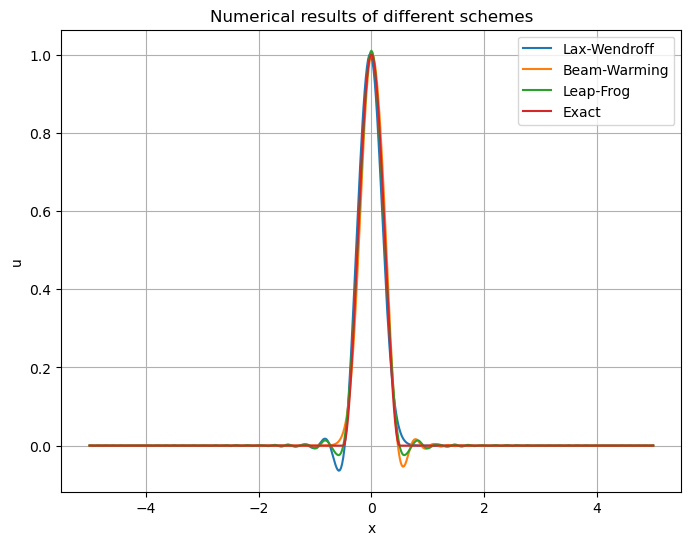

In [20]:
plot_data = {}
for scheme in ['Lax-Wendroff', 'Beam-Warming', 'Leap-Frog']:

    solver = PDEsolver(N_grid=500, init_type=1, scheme=scheme)
    solver.solve()
    plot_data[scheme] = solver.u

plot_data['Exact'] = solver.initial_cond()

x = solver.grid
plt.figure(figsize=(8,6))
for label, y in plot_data.items():
    plt.plot(x, y, label=label)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Numerical results of different schemes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_init_2 = pd.DataFrame(columns=["Scheme","Grid", "R_val", "L_2 error", "L_inf error", "Total variation"])

solver = PDEsolver(N_grid=250, init_type=2, scheme='Lax-Wendroff')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=2, scheme='Lax-Wendroff')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=2, scheme='Beam-Warming')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=2, scheme='Beam-Warming')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=2, R_val=1.75, scheme='Beam-Warming')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=2, R_val=1.75, scheme='Beam-Warming')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=250, init_type=2, scheme='Leap-Frog')
df_init_2.loc[len(df_init_2)] = solver.result()

solver = PDEsolver(N_grid=500, init_type=2, scheme='Leap-Frog')
df_init_2.loc[len(df_init_2)] = solver.result()


L2_conver_result = [
        None if i % 2 == 0 else np.log2( df_init_2['L_2 error'][i-1] / df_init_2['L_2 error'][i] )
        for i in range(len(df_init_2['L_2 error']))
    ]

L_inf_conver_result = [
        None if i % 2 == 0 else np.log2( df_init_2['L_inf error'][i-1] / df_init_2['L_inf error'][i] )
        for i in range(len(df_init_2['L_inf error']))
    ]

df_init_2.insert(loc=4, column='L_2 Convergence order', value=L2_conver_result)
df_init_2.insert(loc=6, column='L_inf Convergence order', value=L_inf_conver_result)

print(df_init_2)

         Scheme  Grid  R_val  L_2 error  L_2 Convergence order  L_inf error  \
0  Lax-Wendroff   250   0.75   0.353034                    NaN     0.659910   
1  Lax-Wendroff   500   0.75   0.278168               0.343853     0.633156   
2  Beam-Warming   250   0.75   0.333599                    NaN     0.618276   
3  Beam-Warming   500   0.75   0.284169               0.231367     0.628526   
4  Beam-Warming   250   1.75   0.292645                    NaN     0.593130   
5  Beam-Warming   750   1.75   0.209157               0.484564     0.616810   
6     Leap-Frog   250   0.75   1.049821                    NaN     1.189753   
7     Leap-Frog   750   0.75   0.256187               2.034874     0.478904   

   L_inf Convergence order  Total variation  
0                      NaN         3.232115  
1                 0.059709         3.728913  
2                      NaN         4.263304  
3                -0.023721         4.884485  
4                      NaN         3.253986  
5           

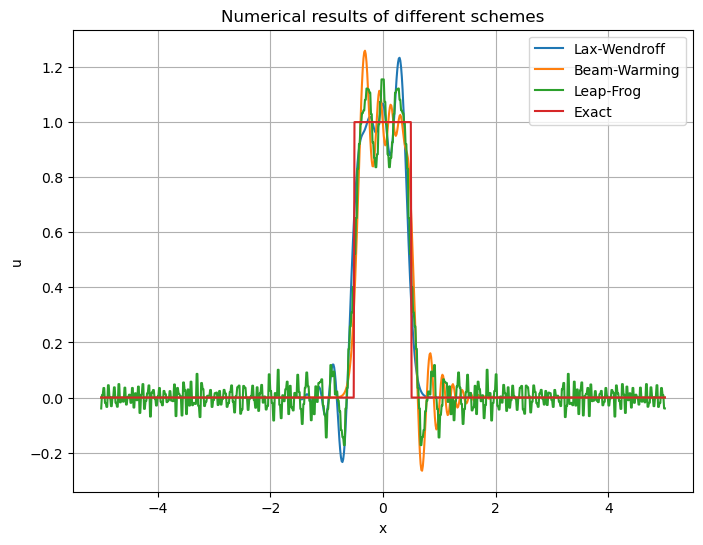

In [ ]:
plot_data = {}
for scheme in ['Lax-Wendroff', 'Beam-Warming', 'Leap-Frog']:

    solver = PDEsolver(N_grid=500, init_type=2, scheme=scheme)
    solver.solve()
    plot_data[scheme] = solver.u

plot_data['Exact'] = solver.initial_cond()

x = solver.grid
plt.figure(figsize=(8,6))
for label, y in plot_data.items():
    plt.plot(x, y, label=label)

plt.xlabel('x')
plt.ylabel('u')
plt.title('Numerical results of different schemes')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

We observe numerical dispersion as the oscilation appears in the solution. 

1. For L-W scheme the dispersion coefficient is negative, so oscillation happens behind the wave. For B-W scheme with R < 1, dispersion coefficient is positive and oscillations happens ahead of the wave. 
2. Leap-Frog scheme is multi-level, which result in two mode with opposite speed for the same wave number (principal root and parasitic root). Oscillation happens both ahead and behind.
3. Dispersion will be much more significant when the initial condition contains high frequency Fourier mode, like square wave. The difference between group speed and phase speed scales with $k^2$.
4. Total variation for two initials are both 2. Larger TVs are observed together with more dispersion.
5. Dispersion will reduce the convergence order of the scheme. 
6. It seems Leap-Frog scheme has significantly larger convergence order over the other two.